In [1]:
from typing import List, Union, Set
import numpy as np

import pandas as pd
from numpy.random import random, choice
import matplotlib.pyplot as plt


from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer
from ydata.metadata import Metadata
from ydata.dataset import Dataset
from ydata.utils.data_types import DataType, VariableType

## Part 1: Data Loading, Model Training and Synthetic dataset generation

PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of a mobile financial service currently running in more than 14 countries all around the world.

The more widely available PaySim dataset can be found here. After YData’s validations, we have identified that the Kaggle dataset (https://www.kaggle.com/ealaxi/paysim1) from a business perspective presents some inconsistencies which will be detailed later in this document. 
To generate a new version of the dataset, we have used the latest code available at the source repository. The dataset used for our experiments can be found here. 

### Listing the available Datasources

In [7]:
from ydata.platform.datasources import DataSources

#listing all the datasources available for a namespace
#This provides information such as the type of datasource and its unique #identifier
available_datasources=DataSources.list()

#Get a particular datasource based on uid
datasource = DataSources.get('fb3338a6-2adc-4ca8-b54f-874b964d0b17')

#Read the full available data
original = datasource.read()

In [8]:
#selecting the relevant columns for the use case
original = original.select_columns(columns=["time", "step", "action", "amount",
                                            "nameOrig", "oldBalanceOrig",
                                            "newBalanceOrig", "nameDest",
                                            "oldBalanceDest", "newBalanceDest",
                                            "isFraud", "isFlaggedFraud",
                                            "isUnauthorizedOverdraft"])

schema = {k: v.value for k, v in original.schema.items()}

df = original.to_pandas()
df = df.sort_values(by="time")
original_cols = df.columns.tolist()

As described by the business context behind PaySim, at each and every **step** all the agents can perform 1 or more transactions. For the particular case of this PaySim dataset:
- Each **step** corresponds to 1 hour;
- The available agents within the dataset, specifically Clients, can act 0 or many times per **step**.
- This means that, for each agent, **step** is not unique, although it defines when the transactions happened.  


As order and uniqueness matters for the process of synthesis, a new feature - **time** - was added. It was also decided to create a few new features while leveraging the **step**, to enhance the information available within the dataset for the synthesization models to leverage during training: 
- Amount mean, standard deviation, minimum, maximum and normalized grouped by **step** and **action**;
- Old balance mean, standard deviation, minimum, maximum and normalized grouped by **step**, **action** and **nameOrig**;
- The percentage of increase/decrease that **amount** caused to *old Balance*;
- The *momentum* of amount grouped by **step** and **action**;
- Lag features for *old balances*.


In [4]:
df["amount_means"] = df.groupby(["step", "action"]).amount.transform(lambda x: x.mean())
df["amount_stds"] = df.groupby(["step", "action"]).amount.transform(lambda x: x.std())
df["amount_mins"] = df.groupby(["step", "action"]).amount.transform(lambda x: x.min())
df["amount_maxs"] = df.groupby(["step", "action"]).amount.transform(lambda x: x.max())
df["amount_norm"] = df["amount"]/df["amount_maxs"]
df['amount_momentum'] = df['amount']/df.groupby(['step', "action"])['amount'].transform(lambda x: x.shift(1))
df["old_balance_orig_means"] = df.groupby(["step", "action", "nameOrig"]).oldBalanceOrig.transform(lambda x: x.mean())
df["old_balance_orig_stds"] = df.groupby(["step", "action", "nameOrig"]).oldBalanceOrig.transform(lambda x: x.std())
df["old_balance_orig_mins"] = df.groupby(["step", "action", "nameOrig"]).oldBalanceOrig.transform(lambda x: x.min())
df["old_balance_orig_maxs"] = df.groupby(["step", "action", "nameOrig"]).oldBalanceOrig.transform(lambda x: x.max())
df["old_balance_norm"] = df["oldBalanceOrig"]/df["old_balance_orig_maxs"]

df["amount_pct"] = df["amount"]/np.maximum(df["oldBalanceOrig"], df["newBalanceOrig"])
df['amount_momentum'] = df['amount']/df.groupby(['step', "action"])['amount'].transform(lambda x: x.shift(1))
for i in range(1, 6):
    df[f"old_balance_orig_lag_{i}"] = df.groupby("nameOrig").oldBalanceOrig.transform(lambda x: x.shift(i))
    df[f"old_balance_dest_lag_{i}"] = df.groupby("nameDest").oldBalanceOrig.transform(lambda x: x.shift(i))

Generating lags
LAG: 1
LAG: 2
LAG: 3
LAG: 4
LAG: 5


In [5]:
extracted_cols = [c for c in df.columns if c not in original_cols]
df[extracted_cols] = df[extracted_cols].fillna(0.0)
for col in extracted_cols:
    schema[col] = "float"

As balances (old and new) can be inferred from the generated amounts and both variables present high correlation, we have decided to drop these features from the synthesis process. This is also a way to ensure the business logic that we have identified within the dataset (relation between the amount, *OldBalanceOrig*, *OldBalanceDest*, *NewBalanceDest* and *NewBalanceOrig*) .


In [6]:
TO_DROP = ["oldBalanceOrig", "newBalanceOrig", "oldBalanceDest", "newBalanceDest"]
dataset = Dataset(df.drop(TO_DROP, axis=1), schema={k:v for k,v in schema.items() if k not in TO_DROP})

metadata = Metadata()
dataset_attrs = {
     "sortbykey": "time",
     "entity_id_cols": ["nameOrig", "nameDest"]
 }
m = metadata(dataset, dataset_attrs)
for c in m.columns:
    if m.columns[c].datatype == DataType.CATEGORICAL and m.columns[c].vartype == VariableType.FLOAT:
        m.columns[c].datatype = DataType.NUMERICAL

synthesizer = TimeSeriesSynthesizer()

[########################################] | 100% Completed | 10.7s
INFO: 2022-04-01 16:52:55,742 [SYNTHESIZER] - Initializing Time Series SYNTHESIZER.


In [8]:
synthesizer.fit(dataset, metadata=m, extracted_cols=extracted_cols)

INFO: 2022-04-01 16:54:07,283 [SYNTHESIZER] - Divide and Conquer: Segmenting by sortbykey
INFO: 2022-04-01 16:54:07,286 [SYNTHESIZER] - Number of segments identified: 10
INFO: 2022-04-01 16:54:07,287 [SYNTHESIZER] - Starting the synthetic data modeling process.
INFO: 2022-04-01 16:54:07,295 [SYNTHESIZER] - Generating pipeline for segment (-0.001, 46046.8]
INFO: 2022-04-01 16:54:07,312 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-04-01 16:54:09,688 [SYNTHESIZER] - Generating pipeline for segment (46046.8, 92093.6]
INFO: 2022-04-01 16:54:09,700 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-04-01 16:54:12,066 [SYNTHESIZER] - Generating pipeline for segment (92093.6, 138140.4]
INFO: 2022-04-01 16:54:12,076 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-04-01 16:54:14,622 [SYNTHESIZER] - Generating pipeline for segment (138140.4, 184187.2]
INFO: 2022-04-01 16:54:14,634 [SYNTHESIZER] - Synthesizer init.
INFO: 2022-04-01 16:54:17,318 [SYNTHESIZER] - Generating pipeline for segment (184187.2, 230

In [9]:
sample_dataset = synthesizer.sample(n_samples=len(dataset.to_pandas()))

sample = sample_dataset.to_pandas()

In [10]:
sample = sample.drop(extracted_cols, axis=1)

## Part 2: Balances generation through calculated features

For the definitions of the function to calculate the balances we had an important initial question: *how to define/set the initial balance?*

As PAYSIM dataset is generated based on multi-agent simulation, we had privilege information, which means, we decided to use the definition that can be found at the <a href="https://github.com/EdgarLopezPhD/PaySim/blob/master/src/main/java/org/paysim/paysim/parameters/BalancesClients.java" target="_blank">initial balances distribution code</a> from PAYSIM’s github repository. 

Below, the strategy to calculate the balances is further detailed:

1. Re-arrange the dataset: Instead of origins and destinys in the same instance, we broke each instance into two: The first is the origin and the second is the destiny (which means that the even indexes are origins and odd indexes are destinys);
2. Generate the cumulative sum for each client by (i) adjusting the amounts signal (if adding or decreasing the balance) based on the action and the type (whether origin or destiny);
3. Estimate the initial balances;
4. Re-arrange the dataset to the original form.

In [63]:
sample = sample.drop(TO_DROP, axis=1, errors="ignore")

c_dist = pd.read_csv('initialBalancesDistribution.csv')
c_dist['range'] = c_dist.range_end - c_dist.range_start
c_dist.loc[301, "percentage"] = 0.0001
c_dist.percentage = c_dist.percentage/c_dist.percentage.sum()

_store_feats = ['time', 'step', 'isFraud', 'isFlaggedFraud']
stored_feats = sample[_store_feats]
sample.drop(_store_feats, axis=1, inplace=True)

sample = sample.set_index(sample.index.values*2)
sample['index_dest'] = sample.index + 1
sample_o = sample.drop(['nameDest', 'index_dest'], axis=1).rename(columns={'nameOrig': 'entity'}).copy()
sample_d = sample.drop(['nameOrig'], axis=1).rename(columns={'nameDest': 'entity'}).set_index('index_dest').copy()

**The initial balance strategy:**

* Initialize Banks and Merchants with 0 (Banks initial balances are always zero and 99.2% of Merchants' initial balances are also);
* If the cumulative sum (without adding the bias of the initial balances) is negative (indicating finishing the transactions with overdraft), the initial balance will be estimated to compensate that (overdraft is still possible, as it is in the original dataset);
* If the cumulative sum is positive, estimate the initial balance from the smallest range.

In [64]:
def get_signal(action, entity, isUnauthorizedOverdraft):
    signal = pd.Series(0, index = action.index)
    return signal.where(cond=(entity.str.startswith('B') | (entity.str.startswith('M') & (action != 'PAYMENT')) | (isUnauthorizedOverdraft==1)),
                        other=(action.isin(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT'])-0.5)*2)

sample_o['update'] = -1*sample_o.amount*get_signal(*[sample_o[c] for c in ['action', 'entity', 'isUnauthorizedOverdraft']])
sample_d['update'] = sample_d.amount*get_signal(*[sample_d[c] for c in ['action', 'entity', 'isUnauthorizedOverdraft']])
vert = pd.concat([sample_o, sample_d], axis=0).sort_index()

vert['newBalance'] = vert[['entity', 'update']].groupby('entity').cumsum()
vert['oldBalance'] = vert[['entity', 'newBalance']].groupby('entity').shift()

vert.oldBalance.fillna(0, inplace=True)

def initial_balances_sampler(vert):
    """Create a balance lookup by sampling an initial balance for each entity in a provided list/set of entities.
    Inputs:
        entities: Collection containing all entities as keys. The first character encodes the entity type."""
    def _client_ib_sampler(c_ents):
        """Mimics the numerical distribution from the source code.
        https://github.com/EdgarLopezPhD/PaySim/blob/master/paramFiles/initialBalancesDistribution.csv"""
        sampled_bins = {}
        for ent, min_value in c_ents.items():
            if min_value >= 0:
                sampled_bin = c_dist.iloc[:1]
                un_sample = random(size=1)
                sampled_bins[ent] = list(sampled_bin.range_start + sampled_bin.range*un_sample)[0]
            else:
                new_c_dist = c_dist[c_dist.range_end > abs(min_value)].copy()
                if len(new_c_dist) == 0:
                    _range = 9000
                    new_c_dist = pd.DataFrame([{"range_start": abs(min_value)-_range/2, "range_end":abs(min_value)+_range/2, "percentage": 1.0, "range":_range}])
                new_c_dist.percentage = new_c_dist.percentage/new_c_dist.percentage.sum()
                new_c_dist = new_c_dist.reset_index(drop=True)
                sampled_bin = new_c_dist.iloc[choice(a=new_c_dist.index, p=new_c_dist.percentage, size=1)]
                un_sample = random(size=1)
                sampled_bins[ent] = list(sampled_bin.range_start + sampled_bin.range*un_sample)[0]
        return sampled_bins

    def _merch_ib_sampler(n: int):
        "99.2% of merchants are initialized with balance of 0."
        return [0]*n

    def _bank_ib_sampler(n: int):
        "Banks are always initialized with balance of 0."
        return [0]*n

    balances = {}
    
    entities = list(vert.entity.unique())
    c_ents = [i for i in entities if i[0] == "C"]
    c_ents = vert[vert.entity.isin(c_ents)].groupby("entity").newBalance.min().to_dict()
    balances.update(_client_ib_sampler(c_ents))
    m_ents = [i for i in entities if i[0] == 'M']
    balances.update(dict(zip(m_ents, _merch_ib_sampler(len(m_ents)))))
    b_ents = [i for i in entities if i[0] == 'B']
    balances.update(dict(zip(b_ents, _bank_ib_sampler(len(b_ents)))))
    return balances
balance_lookup = pd.Series(initial_balances_sampler(vert), name='initial_balances')

in_bal = vert.merge(balance_lookup, how='left', left_on='entity', right_index=True).initial_balances.round(2)
vert['newBalance'] = vert['newBalance'] + in_bal
vert['oldBalance'] = vert['oldBalance'] + in_bal

In the next cell, the dataset rearranging takes place

In [65]:
# Split the origin/destination and reset indexes
sample_o = vert.iloc[::2].reset_index().copy()
sample_d = vert.iloc[1::2].reset_index().copy()

# Rename columns
sample_o.rename(columns={'entity': 'nameOrig', 'oldBalance': 'oldBalanceOrig', 'newBalance': 'newBalanceOrig'}, inplace=True)
sample_d.rename(columns={'entity': 'nameDest', 'oldBalance': 'oldBalanceDest', 'newBalance': 'newBalanceDest'}, inplace=True)

# Concatenations
sample = pd.concat([sample_o, sample_d, stored_feats], axis=1)
sample = sample.loc[:, ~sample.columns.duplicated()][["time", "action", "amount", "nameOrig", "oldBalanceOrig", "newBalanceOrig", "nameDest", "oldBalanceDest", "newBalanceDest", "isFraud", "isFlaggedFraud", "isUnauthorizedOverdraft"]]

## Datasets Comparison

In [49]:
df = df.drop("segments", axis=1, errors="ignore")
df = df.drop(include_cols, axis=1, errors="ignore")
df = df.reset_index(drop=True)1

In [67]:
sample = sample[list(df.columns)]

In [68]:
df

,time,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,1,CASH_IN,229382.36,C3568019779,67.45,229449.80,M1836583048,0.00,0.00,0,0,0
1,1,1,CASH_IN,97393.77,C3961168589,49.69,97443.47,M4632515968,0.00,0.00,0,0,0
2,2,1,CASH_IN,232396.73,C8794318614,29.79,232426.53,M7113244499,0.00,0.00,0,0,0
3,3,1,CASH_IN,155631.49,C8239723447,23748.03,179379.52,M3688842852,0.00,0.00,0,0,0
4,4,1,CASH_IN,122791.96,C8050477779,29.66,122821.61,M4934014946,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440385,3440385,718,TRANSFER,5910291.64,C5990638841,5910291.64,0.00,CC9535772320,0.00,5910291.64,1,0,0
3440386,3440386,718,CASH_OUT,5910291.64,CC9535772320,5910291.64,0.00,M9918967800,274246.35,274246.35,1,0,0
3440387,3440387,718,CASH_OUT,22626.52,C9566319404,3141105.76,3118479.24,M6704182527,220353.38,220353.38,0,0,0
3440388,3440388,718,CASH_IN,157031.75,C6675303407,7378623.17,7535654.92,M4682530668,180430.63,180430.63,0,0,0


In [69]:
sample

,time,step,action,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,isUnauthorizedOverdraft
0,0,1,CASH_IN,229604.48,C3568019779,61.33,229665.81,M1836583048,0.00,0.00,0,0,0
1,1,1,CASH_IN,97257.35,C3961168589,41.58,97298.93,M4632515968,0.00,0.00,0,0,0
2,2,1,CASH_IN,232582.21,C8794318614,13.38,232595.59,M7113244499,0.00,0.00,0,0,0
3,3,1,CASH_IN,155591.26,C8239723447,68.88,155660.14,M3688842852,0.00,0.00,0,0,0
4,4,1,CASH_IN,122791.96,C8050477779,54.37,122846.33,M4934014946,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440385,3440385,718,TRANSFER,5990283.22,C5990638841,6136137.21,145853.99,CC9535772320,14.59,5990297.81,1,0,0
3440386,3440386,718,CASH_OUT,5910291.64,CC9535772320,5990297.81,80006.17,M9918967800,274230.46,274230.46,1,0,0
3440387,3440387,718,CASH_OUT,22626.52,C9566319404,3142301.65,3119675.13,M6704182527,220424.60,220424.60,0,0,0
3440388,3440388,718,CASH_IN,155355.77,C6675303407,7887141.78,8042497.55,M4682530668,180529.68,180529.68,0,0,0


### General Distribution Comparisons

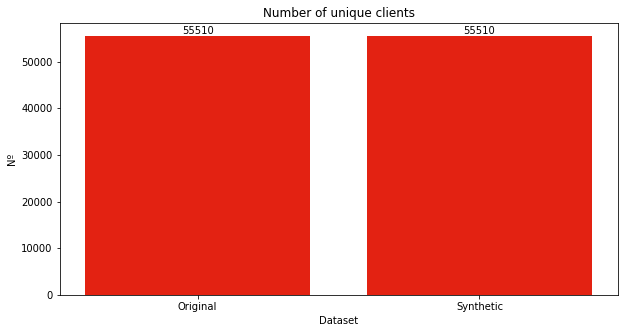

In [86]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.title("Number of unique clients")
plt.ylabel("Nº")
plt.xlabel("Dataset")
n_unique_clients = [len(set(df.nameOrig.unique()).union(df.nameDest.unique())), len(set(sample.nameOrig.unique()).union(sample.nameDest.unique()))]
plt.bar(["Original", "Synthetic"], n_unique_clients, color="#E32212")

rects = ax.patches
labels = n_unique_clients

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

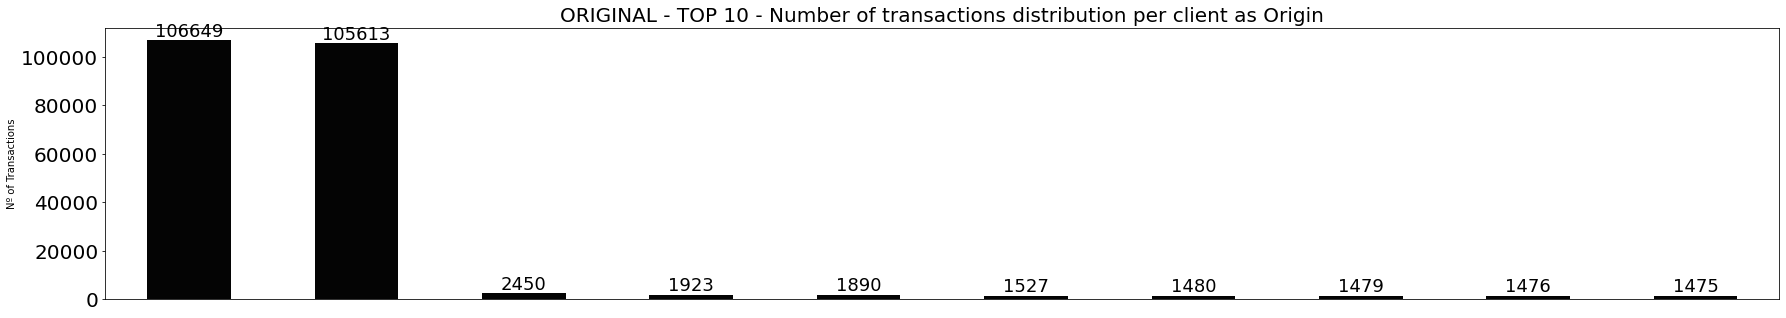

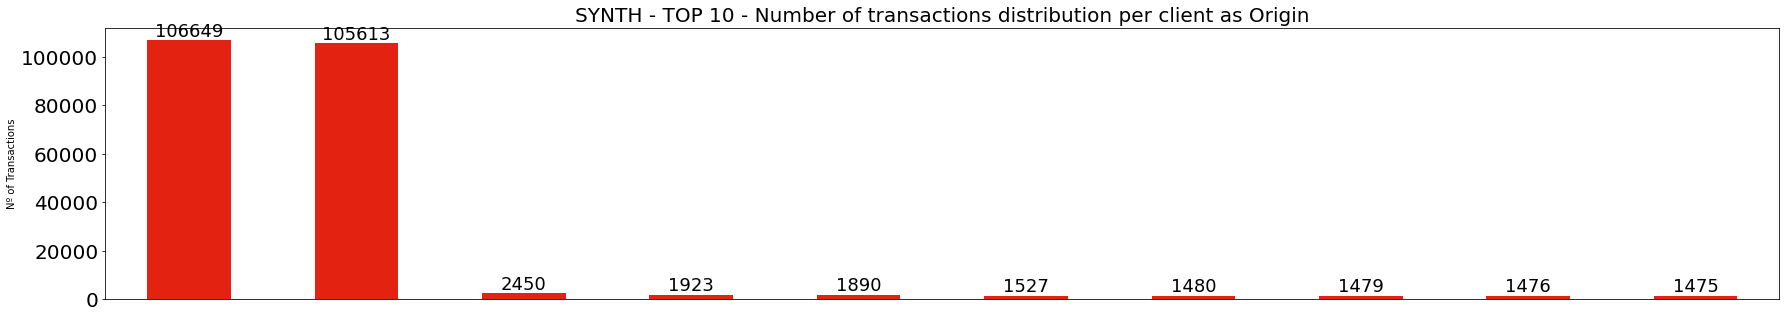

In [87]:
plt.figure(figsize=[30, 5])
plt.title("ORIGINAL - TOP 10 - Number of transactions distribution per client as Origin", fontsize=20)
plt.ylabel("Nº of Transactions")
ax = df.nameOrig.value_counts()[:10].plot.bar(use_index=False, color="#040404", fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.xticks([])
plt.show()

plt.figure(figsize=[30, 5])
plt.title("SYNTH - TOP 10 - Number of transactions distribution per client as Origin", fontsize=20)
plt.ylabel("Nº of Transactions")
ax = sample.nameOrig.value_counts()[:10].plot.bar(use_index=False, color="#E32212", fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.xticks([])
plt.show()

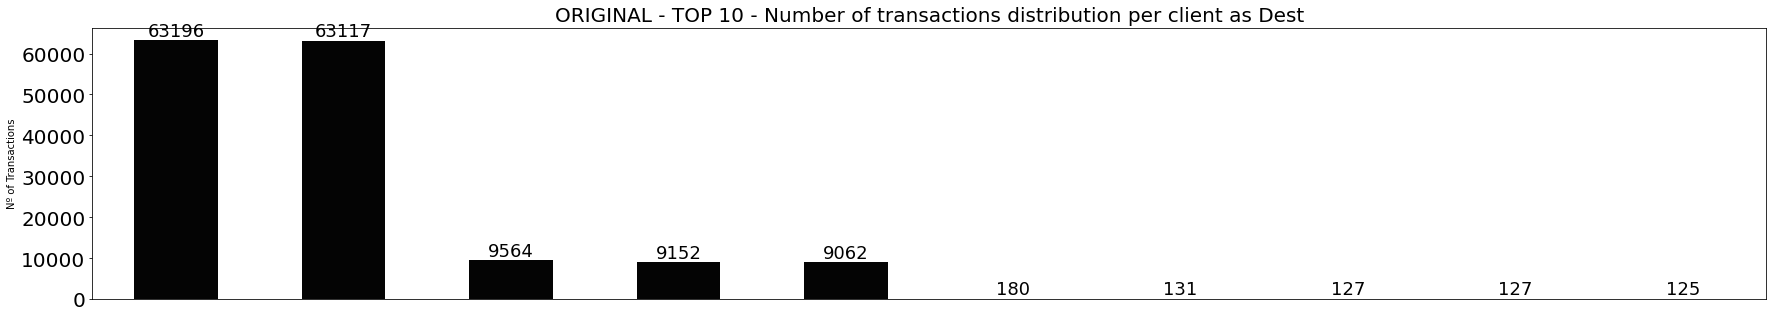

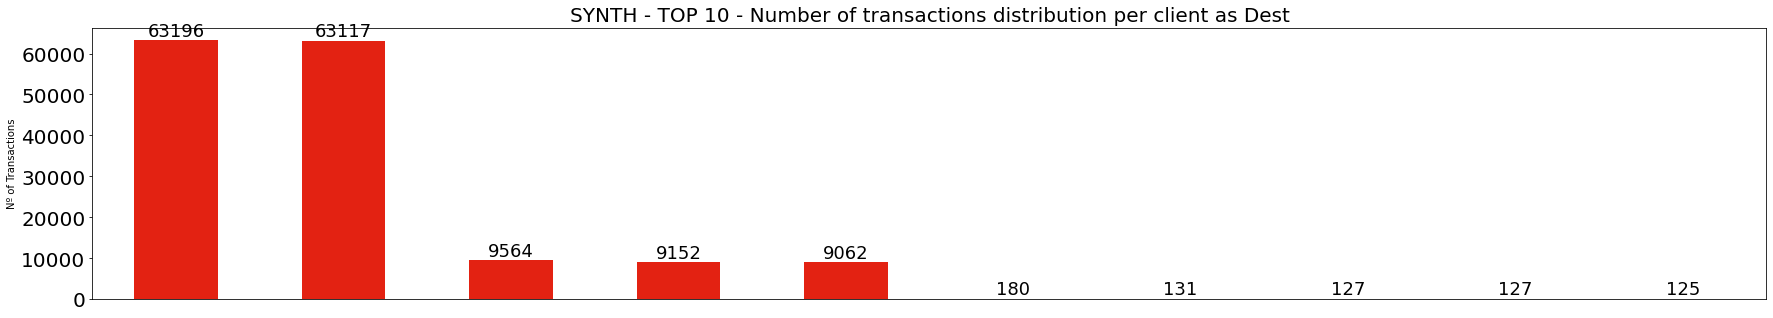

In [88]:
plt.figure(figsize=[30, 5])
plt.title("ORIGINAL - TOP 10 - Number of transactions distribution per client as Dest", fontsize=20)
plt.ylabel("Nº of Transactions")
ax = df.nameDest.value_counts()[:10].plot.bar(use_index=False, color="#040404", fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.xticks([])
plt.show()

plt.figure(figsize=[30, 5])
plt.title("SYNTH - TOP 10 - Number of transactions distribution per client as Dest", fontsize=20)
plt.ylabel("Nº of Transactions")
ax = sample.nameDest.value_counts()[:10].plot.bar(use_index=False, color="#E32212", fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.xticks([])
plt.show()

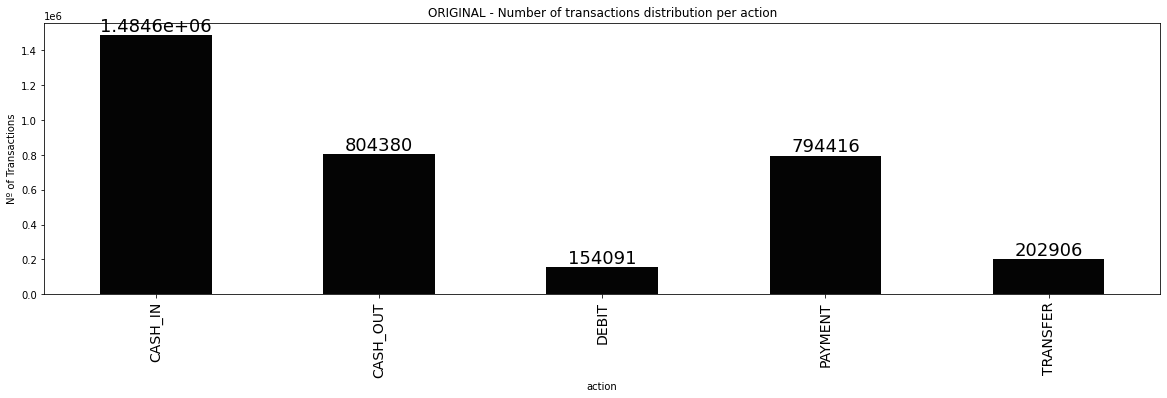

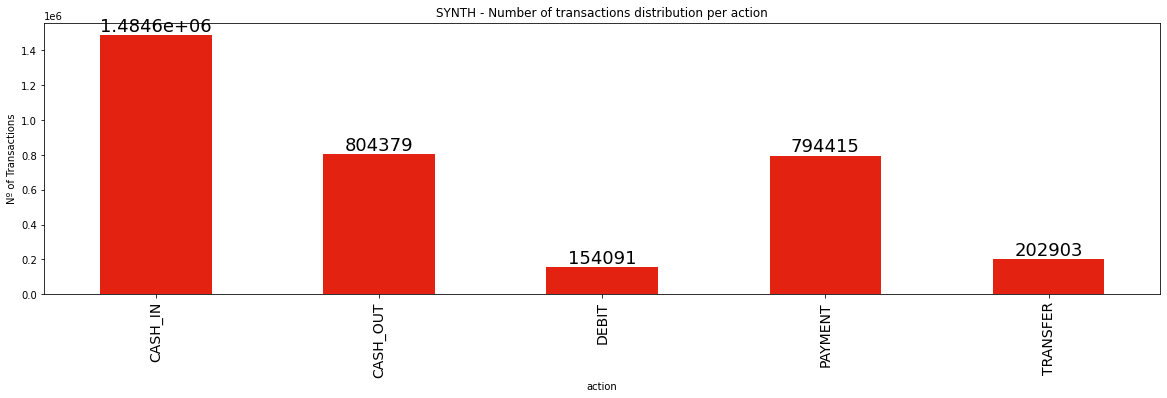

In [89]:
plt.figure(figsize=[20, 5])
plt.title("ORIGINAL - Number of transactions distribution per action")
plt.ylabel("Nº of Transactions")
plt.xlabel("action")
ax = df.action.value_counts().sort_index().plot.bar(color="#040404")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

plt.figure(figsize=[20, 5])
plt.title("SYNTH - Number of transactions distribution per action")
plt.ylabel("Nº of Transactions")
plt.xlabel("action")
ax = sample.action.value_counts().sort_index().plot.bar(color="#E32212")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

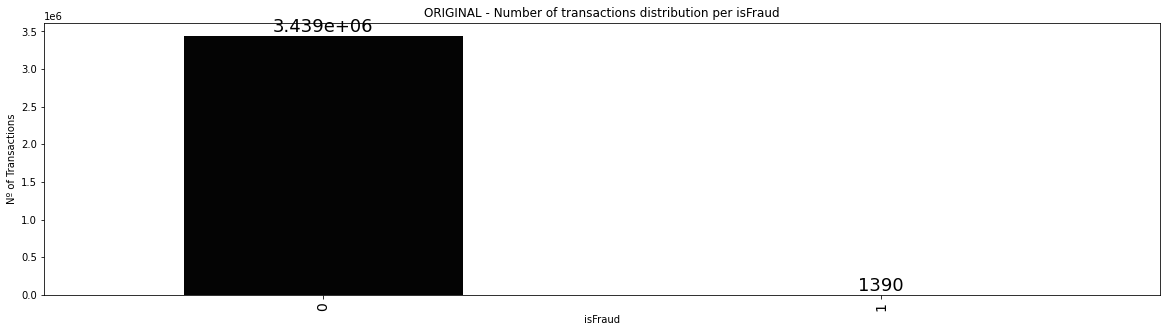

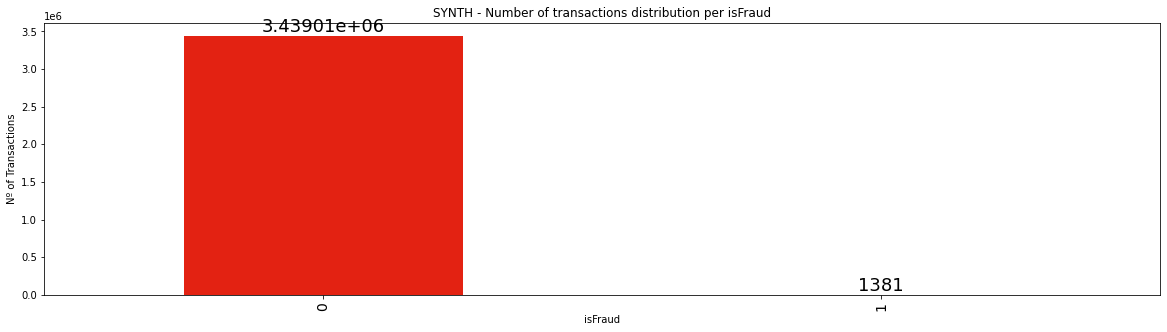

In [90]:
plt.figure(figsize=[20, 5])
plt.title("ORIGINAL - Number of transactions distribution per isFraud")
plt.ylabel("Nº of Transactions")
plt.xlabel("isFraud")
ax = df.isFraud.value_counts().sort_index().plot.bar(color="#040404")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

plt.figure(figsize=[20, 5])
plt.title("SYNTH - Number of transactions distribution per isFraud")
plt.ylabel("Nº of Transactions")
plt.xlabel("isFraud")
ax = sample.isFraud.value_counts().sort_index().plot.bar(color="#E32212")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

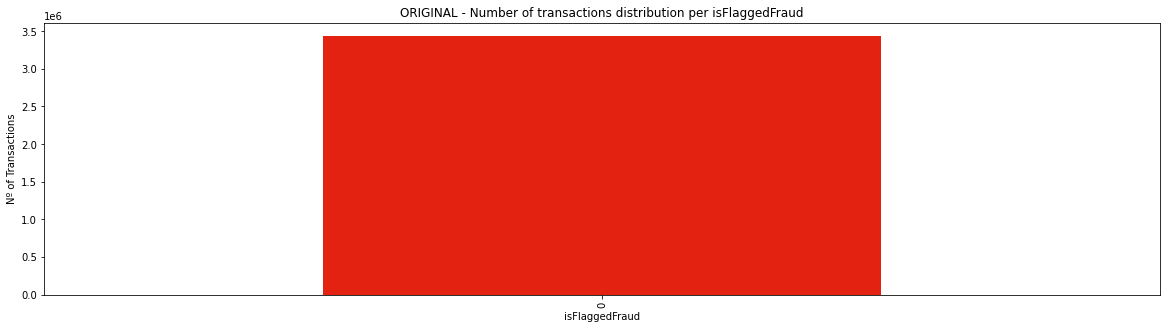

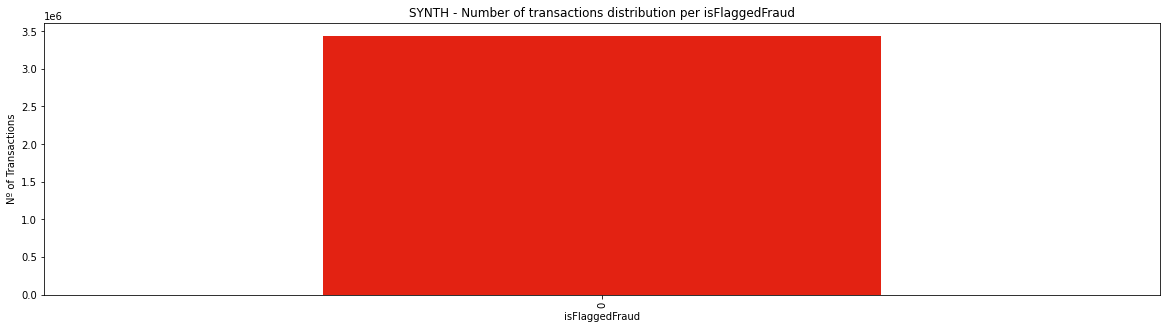

In [91]:
plt.figure(figsize=[20, 5])
plt.title("ORIGINAL - Number of transactions distribution per isFlaggedFraud")
plt.ylabel("Nº of Transactions")
plt.xlabel("isFlaggedFraud")
df.isFlaggedFraud.value_counts().sort_index().plot.bar(color="#E32212")
plt.show()

plt.figure(figsize=[20, 5])
plt.title("SYNTH - Number of transactions distribution per isFlaggedFraud")
plt.ylabel("Nº of Transactions")
plt.xlabel("isFlaggedFraud")
sample.isFlaggedFraud.value_counts().sort_index().plot.bar(color="#E32212")
plt.show()

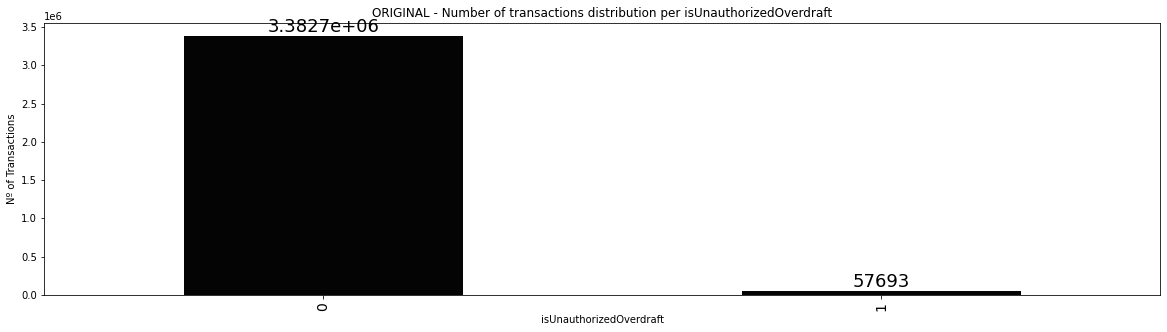

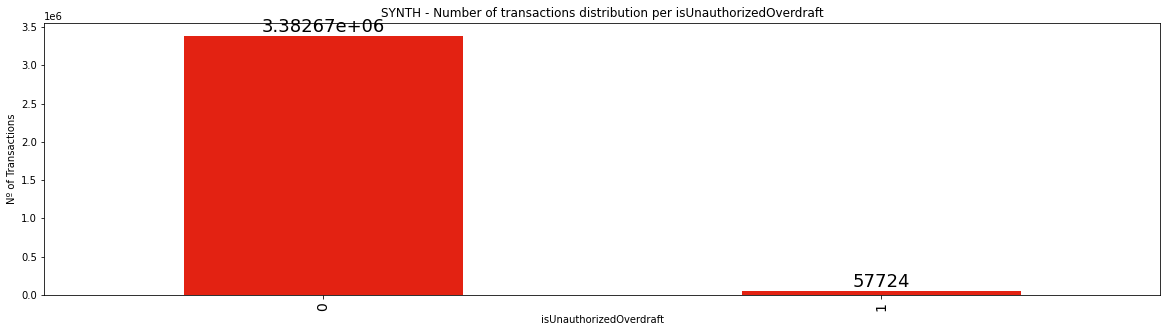

In [92]:
plt.figure(figsize=[20, 5])
plt.title("ORIGINAL - Number of transactions distribution per isUnauthorizedOverdraft")
plt.ylabel("Nº of Transactions")
plt.xlabel("isUnauthorizedOverdraft")
ax = df.isUnauthorizedOverdraft.value_counts().sort_index().plot.bar(color="#040404")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

plt.figure(figsize=[20, 5])
plt.title("SYNTH - Number of transactions distribution per isUnauthorizedOverdraft")
plt.ylabel("Nº of Transactions")
plt.xlabel("isUnauthorizedOverdraft")
ax = sample.isUnauthorizedOverdraft.value_counts().sort_index().plot.bar(color="#E32212")
plt.xticks(fontsize=14)
for container in ax.containers:
    ax.bar_label(container, fontsize=18)
plt.show()

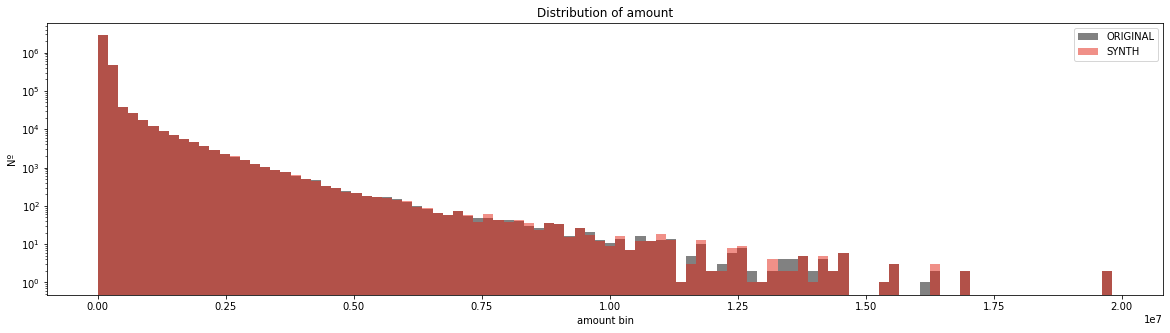

In [93]:
plt.figure(figsize=[20, 5])
plt.title("Distribution of amount")
df.amount.hist(alpha=0.5, label="ORIGINAL", grid=False, color="#040404", bins=100, log=True)
sample.amount.hist(alpha=0.5, label="SYNTH", grid=False, color="#E32212", bins=100, log=True)
plt.xlabel("amount bin")
plt.ylabel("Nº")
plt.legend()
plt.show()

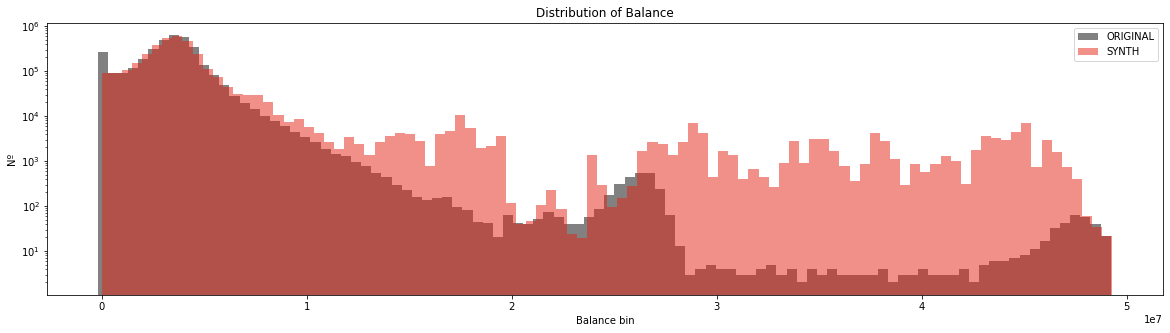

In [80]:
plt.figure(figsize=[20, 5])
plt.title("Distribution of Balance")
df.oldBalanceOrig.hist(alpha=0.5, label="ORIGINAL", grid=False, color="#040404", bins=100, log=True)
sample.oldBalanceOrig.hist(alpha=0.5, label="SYNTH", grid=False, color="#E32212", bins=100, log=True)
plt.xlabel("Balance bin")
plt.ylabel("Nº")
plt.legend()
plt.show()

### Time-series visualizations

In the following visualizations, you can check the behaviour of the mean for amounts and balances: Daily, monthly and yearly.

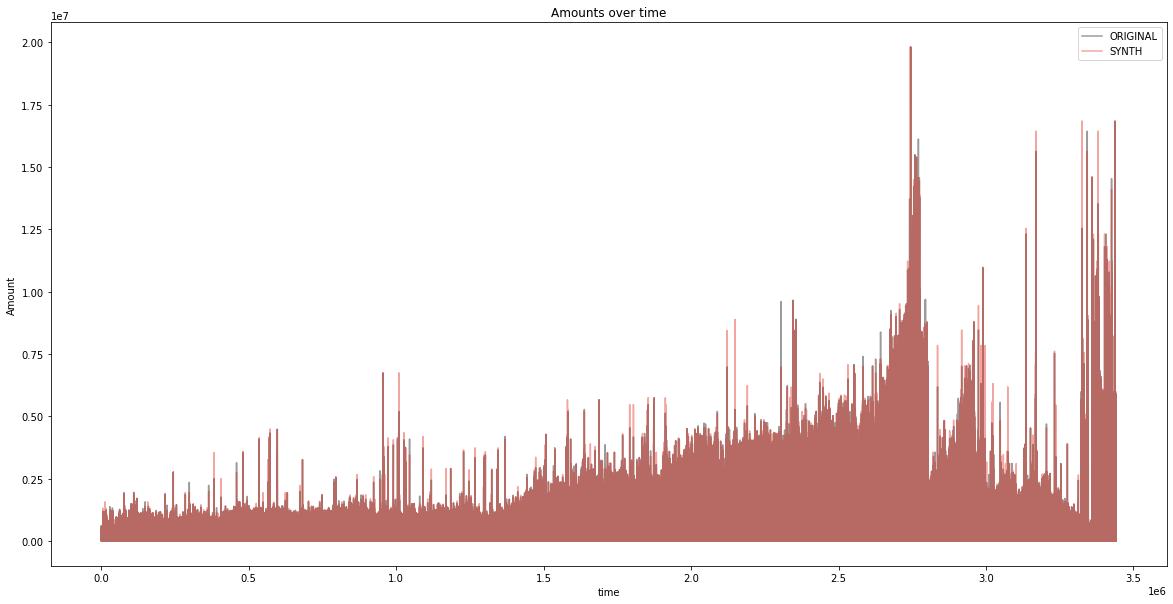

In [94]:
plt.figure(figsize=[20, 10])
plt.title("Amounts over time")
df.groupby("time").amount.mean().plot(label="ORIGINAL", color="#040404", alpha=0.4)
sample.groupby("time").amount.mean().plot(label="SYNTH", color="#E32212", alpha=0.4)
plt.xlabel("time")
plt.ylabel("Amount")
plt.legend()
plt.show()

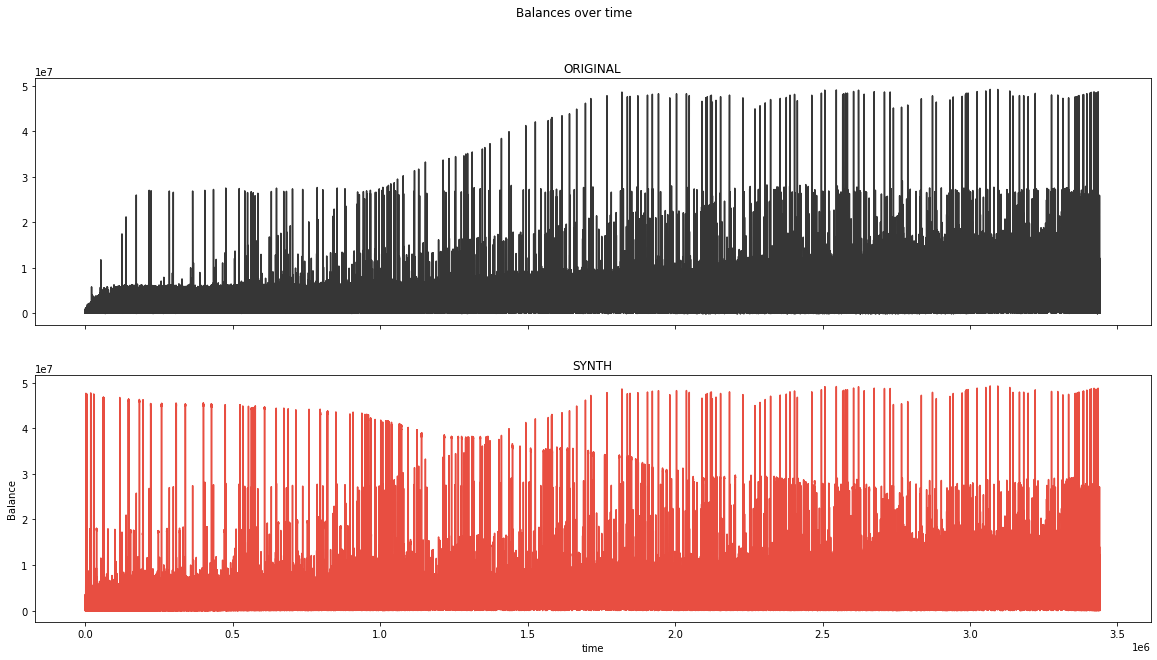

In [99]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=[20, 10])
fig.suptitle("Balances over time")
df.groupby("time").oldBalanceOrig.mean().plot(label="ORIGINAL", color="#040404", alpha=0.8, ax=axs[0], title="ORIGINAL")
sample.groupby("time").oldBalanceOrig.mean().plot(label="SYNTH", color="#E32212", alpha=0.8, ax=axs[1], title="SYNTH")
plt.ylabel("Balance")
plt.xlabel("time")
plt.show()

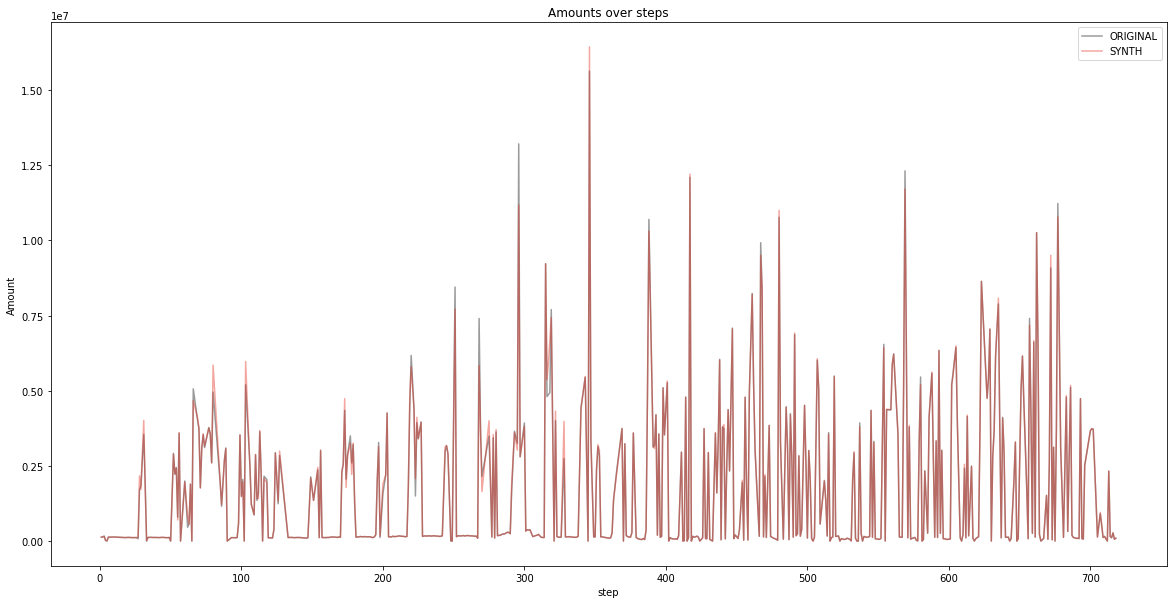

In [83]:
plt.figure(figsize=[20, 10])
plt.title("Amounts over steps")
df.groupby("step").amount.mean().plot(label="ORIGINAL", color="#040404", alpha=0.4)
sample.groupby("step").amount.mean().plot(label="SYNTH", color="#E32212", alpha=0.4)
plt.xlabel("step")
plt.ylabel("Amount")
plt.legend()
plt.show()

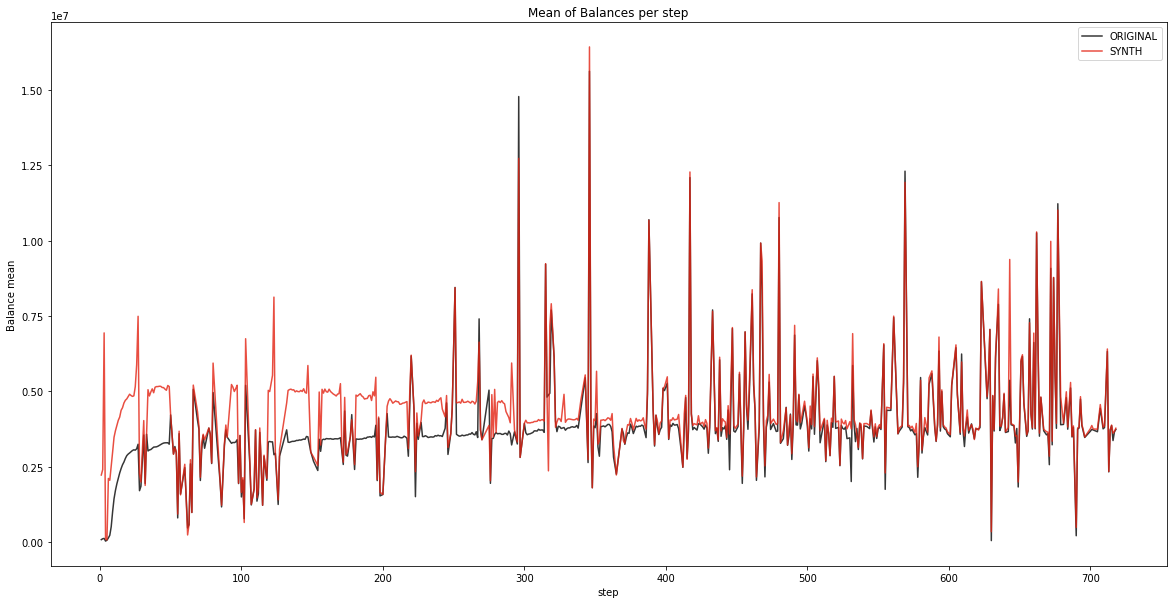

In [84]:
plt.figure(figsize=[20, 10])
plt.title("Mean of Balances per step")
df.groupby("step").oldBalanceOrig.mean().plot(label="ORIGINAL", color="#040404", alpha=0.8)
sample.groupby("step").oldBalanceOrig.mean().plot(label="SYNTH", color="#E32212", alpha=0.8)
plt.xlabel("step")
plt.ylabel("Balance mean")
plt.legend()
plt.show()